### Agent-Lab: Coordinator -> Planner -> Supervisor Agent

Objective of this notebook is evaluating and adapting a [Multi-Agent Supervisor Architecture](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) with coordinator and execution planning steps.

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    TAVILY_API_KEY="???"
    XAI_API_KEY="???"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from IPython.display import Image, Markdown, display
import json

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
# agent = experiment_utils.create_ollama_agent(
#     agent_type="coordinator_planner_supervisor",
#     llm_tag="granite3.2:latest",
#     ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
# )

agent = experiment_utils.create_xai_agent(
    agent_type="coordinator_planner_supervisor",
    llm_tag="grok-2-vision",
    api_key=os.getenv("XAI_API_KEY")
)

# updated_agent = experiment_utils.update_agent_setting(
#     agent_id=agent["id"],
#     setting_key="deep_search_mode",
#     setting_value="True"
# )

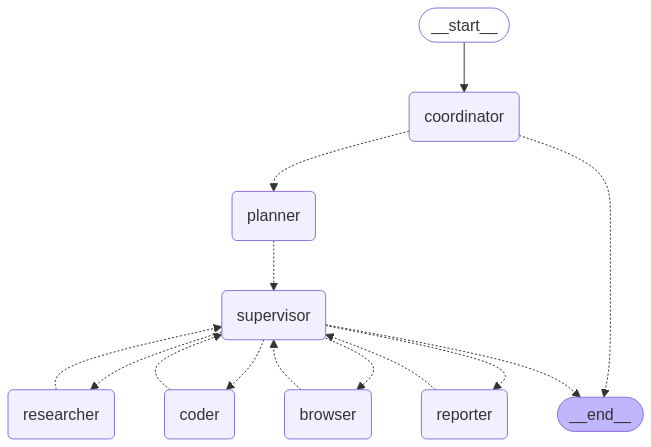

In [3]:
# get agent instance
coordinator_planner_supervisor_agent = container.coordinator_planner_supervisor_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# get config
agent_config = coordinator_planner_supervisor_agent.get_config(agent["id"])

# Create Graph
workflow_builder = coordinator_planner_supervisor_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

### Evaluate Researcher

In [4]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="What characterizes a good general according to Sun Tzu?",
    agent_id=agent["id"]
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [5]:
display(Markdown(f"```json\n{json.dumps(result['execution_plan'], indent=4)}\n```"))

```json
{
    "thought": "The user wants to understand the qualities that Sun Tzu, a famous Chinese military strategist, considers important for a good general. This requires a deep dive into 'The Art of War' and related analyses to compile these characteristics.",
    "title": "Characteristics of a Good General According to Sun Tzu",
    "steps": [
        {
            "agent_name": "researcher",
            "title": "Gather Information on Sun Tzu's Views",
            "description": "**Responsibility**: Use knowledge bases and search engines to gather information on what Sun Tzu identifies as the characteristics of a good general from 'The Art of War' and related scholarly articles. **Output**: A Markdown report detailing these characteristics with citations. **Note**: Focus on direct quotes or paraphrased insights from Sun Tzu's work."
        },
        {
            "agent_name": "reporter",
            "title": "Compile and Present the Report",
            "description": "**Responsibility**: Based on the information gathered by the researcher, compile a professional report that outlines the characteristics of a good general according to Sun Tzu. **Output**: A final report in Markdown format, summarizing the findings in a structured manner."
        }
    ]
}
```

In [6]:
display(Markdown(result["messages"][-1].content))

# Report on Characteristics of a Good General According to Sun Tzu

## Executive Summary
This report delves into Sun Tzu's 'The Art of War' to identify the characteristics that define a good general. Sun Tzu, a revered military strategist from ancient China, outlined several key traits that are essential for effective leadership in warfare.

## Key Findings
- **Deliberation and Planning**: A good general must engage in extensive planning and deliberation before any military action.
- **Rapidity**: Quick decision-making and prompt action are crucial, ensuring the enemy is caught off guard.
- **Clearness of Conception**: A clear understanding of the battlefield and situation is vital for strategic success.
- **Depth of Design**: The ability to formulate deep, strategic plans that are not merely tactical but comprehensive.
- **Terrible in Onset**: The initial attack should be formidable, leveraging the element of surprise and psychological impact.

## Detailed Analysis

### Deliberation and Planning
According to Sun Tzu, warfare begins with careful planning. This involves assessing the situation, understanding the enemy, and preparing strategies that are not easily countered. Sun Tzu states, "The art of war is of vital importance to the State," highlighting the necessity of this planning for national survival.

### Rapidity
Sun Tzu advocates for speed in military decisions and actions. He notes, "Therefore the good fighter will be terrible in his onset, and prompt in his decision." This suggests that a good general should seize opportunities swiftly, akin to a falcon's sudden strike, to maintain the advantage.

### Clearness of Conception
A good general must possess a clear vision of the battlefield dynamics. Sun Tzu's work emphasizes that clarity in understanding leads to effective strategies, preventing confusion and missteps during the campaign.

### Depth of Design
Beyond simple tactics, Sun Tzu values the ability to design strategies with depth. This means anticipating multiple outcomes, preparing for contingencies, and ensuring that plans have layers that can adapt to changing circumstances.

### Terrible in Onset
The initial engagement should be overwhelming. Sun Tzu's philosophy includes making the first move so impactful that it demoralizes the enemy, leveraging the psychological aspect of warfare.

## Conclusions and Recommendations
- **For Military Leaders**: Incorporate Sun Tzu's principles into modern military training, focusing on strategic depth, clarity, and the psychological impact of initial actions.
- **For Strategic Thinkers**: Apply these characteristics in business or competitive environments where strategy plays a crucial role, adapting the concepts of rapidity and clear planning to non-military contexts.

**Source**: All information is derived from Sun Tzu's 'The Art of War', with specific reference to the provided text and general understanding of his philosophy.

**Note**: The analysis is strictly based on the provided excerpts from Sun Tzu's work. No additional information was used or assumed.

### Evaluate Coder

In [ ]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content=(
        "Please create a compound interest calculator in Python. "
        "What would be interest paid on a principal of 175k with rate 4.89/year for 15 years?"),
    agent_id=agent["id"]
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [ ]:
display(Markdown(f"```json\n{json.dumps(result['execution_plan'], indent=4)}\n```"))

In [ ]:
display(Markdown(result["messages"][-1].content))

### Evaluate Browser

In [ ]:
# %%capture
message = MessageRequest(
    message_role="human",
    message_content=(
        "Go to https://en.wikipedia.org/wiki/Mathematical_finance and summarize the overview."),
    agent_id=agent["id"]
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [ ]:
display(Markdown(f"```json\n{json.dumps(result['execution_plan'], indent=4)}\n```"))

In [ ]:
display(Markdown(result["messages"][-1].content))

In [ ]:
display(Image(filename="notebooks/coordinator_planner_supervisor_agent.gif"))